<div align="center" style="background-color: #f5f5f5; padding: 20px; border-radius: 10px; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1); color: #555;">

# Flowers Recognition
### A Convolutional Neural Network with 6.5M Learnable Petals
###### ITHS AI22 Deep Learning Course | December 2023
</div>

[This dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
) contains 4242 images of flowers.

### Content

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size.

The data collection is based on scraped data from flickr, google images, and yandex images. Our task is to build a convolutional network that serves as a flower prediction model.

### Description

ReLU is used as activation function for all convolutional layers and the first dense layer. ReLU is a commonly used activation function that helps the model learn complex patterns in the data. The dense layer uses softmax to make a prediction on the flower category. The loss function used in this model is Categorical Cross-Entropy, it's suitable for a multi-class classification problem, where each input sample can belong to one class only.

A standard normalization is applied on the images, where pixel value of the color channels are divided by 255, this is common practise in image processing and improves the stability and convergence during training. 

##### **Before dataset curation**

The performance is barely decent. The model could be improved by curating the dataset, making it more balanced by removing deviated images with dubious features (drawings of flowers, flowers not the main element of the image, simply put: removing bad images.) Once the dataset has been curated, the performance could additionally be improved by data augmentation (extending the dataset with augmentations). The training could also be improved by implementing and adjusting more hyperparameters, such as learning steps.

##### **After dataset curation**

The performance is good. I excludeed about 40% of the entire dataset, we could improve the model further with data augmentation and adjusting hyperparams.

### Resources & Documentation

[api_docs/tf/keras/utils/image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

[tensorflow.org/tutorials/images/classification](https://www.tensorflow.org/tutorials/images/classification)


# Creating a dataset (Train|Val|Test Split) + Cleaning, Normalization & Encoding

The original dataset is a mess. It would actually need more than the 5 labels. For example, dandelion should be split into *dandelion puff* and *dandelion flower*. (Yellow flower stage & fluffy seed-bearing stage.

I have removed the following samples from the ds:
- Photo does not contain element (target flower missing in photo)
- Photo contain other flowers not in target label (multiple different flowers)
- Photo does not have target label as main element (flower is in background/foreground)
- Photo does not contain actual flower (e.g., Daisy could be a person, not a flower)
- Photo is close-up but target element is not centered (we crop all images to 1:1 aspect ratio)
- Photo has too wide focal length (unexpected lens distortion)
- Photo is extreme macro
- Photo is over- or underexposed
- Photo is heavily post-processed (unnatural color balance, applied color filter/texture)
- Photo has too extreme aspect ratio (we crop all images to 1:1 aspect)
- Photo is low resolution
- Photo contain distruptive elements (view obstructed by person/animal/object)
- Photo contain borders och heavy vignette (also post processed)
- Photo is not sharp (target element blurry/in bokeh or camera shutter speed it too low)
- Photo contains text overlays 
- Photo is not photo (is drawing)
- Photo is composed of multiple photos

This is all removed because we want to use 'natural' photos with 'ordinary' flowers from a relatively 'normal' camera perspective.

We first start out by creating our dataset. For this we use the `image_dataset_from_directory` API.<br>
The images are resized, shuffled and encoded. (More on this later.) A random seed is provided as for reproducibility.<br>

We use the take & skip methods to move a couple of train images into test images, however we *could* use the entire dataset for training and validation, and run inferrence on our own photos.

This results in:

xx% training:
- xx% training is used to adjust the weights in the network.
- xx% in-training validation used only to check metrics of the model after each epoch.

xx% testing (never seen by the training process at all)

**#TODO update values when satisfied with inference**

I've decided to run with a larger batch size (128) because there is high variance in the dataset. Edit: I was wrong about this, a smaller batch size yield better results.

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory as get_data
from tensorflow import one_hot

def create_dataset(data_dir='Data/curated_flowers', batch_size=128, img_size=(224,224), val_size=0.2, shuffle=True, random_seed=42, test_images=6, normalize=True):

    print(f"Creating dataset with batch size: {batch_size}")

    train_ds = get_data(
      data_dir,
      validation_split=val_size,
      subset="training",
      seed=random_seed,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=shuffle)

    val_ds = get_data(
      data_dir,
      validation_split=val_size,
      subset="validation",
      seed=random_seed,
      image_size=img_size,
      batch_size=batch_size,
      shuffle=shuffle)

    # One-hot encoding labels
    class_names = train_ds.class_names
    try:
        num_classes = len(train_ds.class_names)
        train_ds = train_ds.map(lambda x, y: (x, one_hot(y, depth=num_classes)))
        val_ds = val_ds.map(lambda x, y: (x, one_hot(y, depth=num_classes)))
        print('Labels successfully encoded.')
    except Exception as e:
        print(f'Error during one-hot encoding: {e}')

    if test_images != 0:
        test_ds = train_ds.take(test_images)
        new_train_ds = train_ds.skip(test_images)
        print(f"Moving {len(test_ds)} images from training to test.")

    if normalize:
        try:
            val_ds = val_ds.map(normalize_image)
            if test_images != 0:
                test_ds = test_ds.map(normalize_image)
                new_train_ds = new_train_ds.map(normalize_image)
            else:
                new_train_ds = train_ds.map(normalize_image)
            print('Images successfully normalized.')
        except Exception as e:
            print(f'Error during normalization: {e}')
    else:
        new_train_ds = train_ds
        
    if test_images != 0:
        return new_train_ds, val_ds, test_ds, class_names
    else:
        return new_train_ds, val_ds, class_names

def normalize_image(img, label):
    return img / 255, label


In [10]:
train_ds, val_ds, test_ds, class_names = create_dataset(shuffle=True, random_seed=3)

Creating dataset with batch size: 128
Found 2714 files belonging to 5 classes.
Using 2172 files for training.
Found 2714 files belonging to 5 classes.
Using 542 files for validation.
Labels successfully encoded.
Moving 6 images from training to test.
Images successfully normalized.


When using `image_dataset_from_directory`, labes are automatically integer encoded in the dataset. One integer represent one type of flower.<br>
For multi-class classification tasks (like identifying different types of flowers), it is common to employ a technique one-hot encoding.

With one-hot encoding, we instead get a unique binary matrix for each category, this helps the softmax activated output layer.

And a snippet of a tensor channel:

```
tf.Tensor(
[[[ 65.03571   132.03572   184.03572  ]
  [ 66.        133.        185.       ]
  [ 66.17857   133.17857   185.35715  ]
  ...
```

When we use the map function on a tf.data.Dataset (or PrefetchDataset), we apply a function (such as `normalize_image`) to each element of the dataset.

After normalization:

```
tf.Tensor(
[[[0.14509805 0.14509805 0.11372549]
  [0.14509805 0.14509805 0.11372549]
  [0.14621848 0.14621848 0.11484594]
  ...
  ```

  As such we divide each pixel value by 255, bringing the values into the range [0, 1]. This improves consistecy and helps the model to learn faster (faster convergence).

# Building the model

Here we use a modified base model as desribed in the [Keras Image classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).<br>
No regularization has been applied in this version of the model.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def get_model(img_size=[224,224],                   # Could be changged
              num_classes=5,                        # Cannot be changed unless dataset is rebuilt with new labels
              num_filters=[16, 32, 64],             # Could try more
              pooling_sizes=[2, 2, 2],              # Have not yet tried other sized
              activations=['relu', 'relu', 'relu'], # Should probably not be changed, but could test different
              dense_units=[128],                    # Could test different
              dense_activations=['relu'],           # Should probably not be changed, but could test different
              optimizer='adam',                     # Tested along with SGD
              loss='categorical_crossentropy',      # Implemented but have not tried other loss fn (e.g., sparse cce)
              learning_rate=0.001):                 # Not implemented

    model = Sequential()

    for filters, pooling_size, activation in zip(num_filters, pooling_sizes, activations):
        model.add(Conv2D(filters, 3, padding='same', activation=activation, input_shape=(img_size[0], img_size[1], 3)))
        model.add(MaxPooling2D(pool_size=pooling_size))

    model.add(Flatten())

    for units, activation in zip(dense_units, dense_activations):
        model.add(Dense(units, activation=activation))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

The total and trainable parameters look reasonable. The model is trainable with ~6.4 million parameters.

# Training the model & plotting training results

Now we'll call our `get_model()` to instantiate and compare two optimization algorithms, Adam and SGD.
With the Keras API we can simplify this.

In [11]:
from tqdm.keras import TqdmCallback

def train(model, train_ds, val_ds, epochs=6):
    tqdm_callback = TqdmCallback()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[tqdm_callback])
    return history

In [12]:
val_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [13]:
adam6 = get_model()
sgd6 = get_model(optimizer='sgd')
hist_adam = train(adam6, train_ds, val_ds, epochs=6)
hist_sgd = train(sgd6, train_ds, val_ds, epochs=6)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
11/11 [==============================] - 30s 3s/step - loss: 1.9693 - accuracy: 0.2550 - val_loss: 1.5046 - val_accuracy: 0.3524
Epoch 2/6
11/11 [==============================] - 30s 3s/step - loss: 1.3952 - accuracy: 0.4110 - val_loss: 1.2442 - val_accuracy: 0.4963
Epoch 3/6
11/11 [==============================] - 32s 3s/step - loss: 1.1031 - accuracy: 0.5356 - val_loss: 1.0309 - val_accuracy: 0.5793
Epoch 4/6
11/11 [==============================] - 31s 3s/step - loss: 0.9017 - accuracy: 0.6204 - val_loss: 0.9765 - val_accuracy: 0.6199
Epoch 5/6
11/11 [==============================] - 30s 3s/step - loss: 0.8252 - accuracy: 0.6766 - val_loss: 0.9860 - val_accuracy: 0.6107
Epoch 6/6
11/11 [==============================] - 29s 2s/step - loss: 0.7240 - accuracy: 0.7308 - val_loss: 0.9034 - val_accuracy: 0.6273


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
11/11 [==============================] - 29s 2s/step - loss: 1.5861 - accuracy: 0.2735 - val_loss: 1.5651 - val_accuracy: 0.2491
Epoch 2/6
11/11 [==============================] - 29s 2s/step - loss: 1.5542 - accuracy: 0.3084 - val_loss: 1.5250 - val_accuracy: 0.3284
Epoch 3/6
11/11 [==============================] - 30s 3s/step - loss: 1.5032 - accuracy: 0.3818 - val_loss: 1.4892 - val_accuracy: 0.3358
Epoch 4/6
11/11 [==============================] - 29s 3s/step - loss: 1.4411 - accuracy: 0.4046 - val_loss: 1.4034 - val_accuracy: 0.4686
Epoch 5/6
11/11 [==============================] - 28s 2s/step - loss: 1.4587 - accuracy: 0.3739 - val_loss: 1.3939 - val_accuracy: 0.3893
Epoch 6/6
11/11 [==============================] - 29s 2s/step - loss: 1.3740 - accuracy: 0.4217 - val_loss: 1.4032 - val_accuracy: 0.3376


Before dataset curation:

```
ADAM
Epoch 6/6
27/27 [==============================] - 63s 2s/step - loss: 0.5571 - accuracy: 0.7976 - val_loss: 237.8900 - val_accuracy: 0.5456

SGD
Epoch 6/6
27/27 [==============================] - 65s 2s/step - loss: 1.1621 - accuracy: 0.5240 - val_loss: 101.1557 - val_accuracy: 0.4844
```

SGD performs worse. Very interesting.

In [16]:
import plotly.graph_objects as go

def plot_training(*histories, title="None", names=None):
    fig = go.Figure()
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = list(range(1, len(acc) + 1))

        fig.add_trace(go.Scatter(x=epochs_range, y=acc, mode='lines', name=f'{names[i]} Training Accuracy'))
        fig.add_trace(go.Scatter(x=epochs_range, y=val_acc, mode='lines', name=f'{names[i]} Validation Accuracy'))

    fig.update_layout(title=title,
                      xaxis_title='Epochs',
                      yaxis_title='Accuracy')

    fig.show()

plot_training(hist_adam, hist_sgd, title='Train & Val Accuracy Comparison (Batch Size=128), no regularizaion.', names=['Adam', 'SGD'])

Adam overfits. SGD seems a bit more stable but slow.. We should try to implement some regularizations.

In [18]:
def get_model_heavy_regularization(img_size=[224,224],
                                   num_classes=5,
                                   num_filters=[16, 32, 64],
                                   pooling_sizes=[2, 2, 2],
                                   activations=['relu', 'relu', 'relu'],
                                   dense_units=[128],
                                   dense_activations=['relu'],
                                   dropout_rate=0.388,
                                   optimizer='adam',
                                   loss='categorical_crossentropy'):

    model = Sequential()

    for filters, pooling_size, activation in zip(num_filters, pooling_sizes, activations):
        model.add(Conv2D(filters, 3, padding='same', activation=activation, input_shape=(img_size[0], img_size[1], 3)))
        model.add(MaxPooling2D(pool_size=pooling_size))

    model.add(Flatten())

    for units, activation in zip(dense_units, dense_activations):
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

model_heavy_reg = get_model_heavy_regularization()
model_heavy_reg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 28, 28, 64)       

In [19]:
adam_re = train(get_model_heavy_regularization(), train_ds, val_ds, epochs=6)
sgd_reg = train(get_model_heavy_regularization(optimizer='sgd'), train_ds, val_ds, epochs=6)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
11/11 [==============================] - 30s 2s/step - loss: 2.0026 - accuracy: 0.2265 - val_loss: 1.5904 - val_accuracy: 0.3137
Epoch 2/6
11/11 [==============================] - 30s 3s/step - loss: 1.5154 - accuracy: 0.3312 - val_loss: 1.4026 - val_accuracy: 0.3819
Epoch 3/6
11/11 [==============================] - 30s 3s/step - loss: 1.2664 - accuracy: 0.4416 - val_loss: 1.1978 - val_accuracy: 0.4852
Epoch 4/6
11/11 [==============================] - 30s 3s/step - loss: 1.1145 - accuracy: 0.5036 - val_loss: 1.0737 - val_accuracy: 0.5387
Epoch 5/6
11/11 [==============================] - 29s 3s/step - loss: 1.0081 - accuracy: 0.5862 - val_loss: 0.9943 - val_accuracy: 0.5849
Epoch 6/6
11/11 [==============================] - 30s 3s/step - loss: 0.9557 - accuracy: 0.6182 - val_loss: 0.9620 - val_accuracy: 0.6070


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
11/11 [==============================] - 32s 3s/step - loss: 1.5987 - accuracy: 0.2457 - val_loss: 1.5764 - val_accuracy: 0.2657
Epoch 2/6
11/11 [==============================] - 30s 3s/step - loss: 1.5624 - accuracy: 0.3127 - val_loss: 1.5465 - val_accuracy: 0.2934
Epoch 3/6
11/11 [==============================] - 28s 2s/step - loss: 1.5370 - accuracy: 0.3405 - val_loss: 1.5061 - val_accuracy: 0.3985
Epoch 4/6
11/11 [==============================] - 29s 2s/step - loss: 1.4844 - accuracy: 0.3675 - val_loss: 1.4546 - val_accuracy: 0.3561
Epoch 5/6
11/11 [==============================] - 29s 2s/step - loss: 1.4386 - accuracy: 0.3796 - val_loss: 1.3877 - val_accuracy: 0.4760
Epoch 6/6
11/11 [==============================] - 28s 2s/step - loss: 1.3740 - accuracy: 0.4259 - val_loss: 1.3949 - val_accuracy: 0.3653


Before curation:
```
ADAM
Epoch 6/6
27/27 [==============================] - 66s 2s/step - loss: 0.6095 - accuracy: 0.7762 - val_loss: 159.7308 - val_accuracy: 0.5578

SGD
Epoch 6/6
27/27 [==============================] - 65s 2s/step - loss: 1.2985 - accuracy: 0.4517 - val_loss: 117.8223 - val_accuracy: 0.4313
```
An increase for Adam but a decrease in Validation Accuracy for SGD again. Although slightly above the non-curated ds at fifth epoch.

In [20]:
plot_training(adam_re, sgd_reg, title='Train & Val Accuracy Comparison (Batch Size=128), Heavy regularizaion.', names=['Adam', 'SGD'])

Adam still overfits, but looks a bit more promising. SGD actually underfits this time, but looks to stabilize after the 6th epoch. It would be interesting to continue training.<br>
I might have initially been wrong about using larger batch sizes. Let's try the regularized model on smaller batches.

In [21]:
train_ds, val_ds, test_ds, class_names = create_dataset(shuffle=True, random_seed=3, batch_size=32)

Creating dataset with batch size: 32


Found 2714 files belonging to 5 classes.
Using 2172 files for training.
Found 2714 files belonging to 5 classes.
Using 542 files for validation.
Labels successfully encoded.
Moving 6 images from training to test.
Images successfully normalized.


In [22]:
adam_re_32 = train(get_model_heavy_regularization(), train_ds, val_ds, epochs=6)
sgd_reg_32 = train(get_model_heavy_regularization(optimizer='sgd'), train_ds, val_ds, epochs=6)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
62/62 [==============================] - 42s 648ms/step - loss: 1.2578 - accuracy: 0.4561 - val_loss: 1.0629 - val_accuracy: 0.5756
Epoch 2/6
62/62 [==============================] - 38s 603ms/step - loss: 0.9335 - accuracy: 0.6187 - val_loss: 0.8969 - val_accuracy: 0.6365
Epoch 3/6
62/62 [==============================] - 38s 596ms/step - loss: 0.7743 - accuracy: 0.7020 - val_loss: 0.8084 - val_accuracy: 0.6900
Epoch 4/6
62/62 [==============================] - 39s 620ms/step - loss: 0.5723 - accuracy: 0.7955 - val_loss: 0.7820 - val_accuracy: 0.7140
Epoch 5/6
62/62 [==============================] - 39s 613ms/step - loss: 0.5096 - accuracy: 0.8212 - val_loss: 0.7902 - val_accuracy: 0.7196
Epoch 6/6
62/62 [==============================] - 40s 641ms/step - loss: 0.3057 - accuracy: 0.8909 - val_loss: 0.8825 - val_accuracy: 0.7177


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/6
62/62 [==============================] - 37s 584ms/step - loss: 1.5240 - accuracy: 0.3197 - val_loss: 1.3679 - val_accuracy: 0.4889
Epoch 2/6
62/62 [==============================] - 37s 591ms/step - loss: 1.3519 - accuracy: 0.4374 - val_loss: 1.2606 - val_accuracy: 0.4483
Epoch 3/6
62/62 [==============================] - 39s 614ms/step - loss: 1.1823 - accuracy: 0.5056 - val_loss: 1.1432 - val_accuracy: 0.5037
Epoch 4/6
62/62 [==============================] - 40s 630ms/step - loss: 1.0989 - accuracy: 0.5202 - val_loss: 1.0573 - val_accuracy: 0.5517
Epoch 5/6
62/62 [==============================] - 39s 615ms/step - loss: 1.0217 - accuracy: 0.5687 - val_loss: 1.1275 - val_accuracy: 0.5185
Epoch 6/6
62/62 [==============================] - 39s 619ms/step - loss: 0.9815 - accuracy: 0.5990 - val_loss: 1.1609 - val_accuracy: 0.5203


Before curation:
```
ADAM:
Epoch 6/6
108/108 [==============================] - 69s 637ms/step - loss: 0.4734 - accuracy: 0.8176 - val_loss: 266.7127 - val_accuracy: 0.5102

SGD:
Epoch 6/6
108/108 [==============================] - 65s 601ms/step - loss: 1.0257 - accuracy: 0.5929 - val_loss: 219.1905 - val_accuracy: 0.4680
```

With a batch size of 32, both models saw relatively big improvements on the curated ds. I was wrong when I initially thought a bigger batch size would be better for this data. If the variance is high, we should use a smaller batch size.

In [23]:
plot_training(adam_re_32, sgd_reg_32, title='Train & Val Accuracy Comparison (Batch Size=32), Heavy regularizaion.', names=['Adam', 'SGD'])

Let's change batch size to 16 and continue training Adam with an increased dropout.

In [28]:
train_ds, val_ds, test_ds, class_names = create_dataset(shuffle=True, random_seed=3, batch_size=16, val_size=0.2)

Creating dataset with batch size: 16
Found 2714 files belonging to 5 classes.
Using 2172 files for training.
Found 2714 files belonging to 5 classes.
Using 542 files for validation.
Labels successfully encoded.
Moving 6 images from training to test.
Images successfully normalized.


In [29]:
regularized_adam = get_model_heavy_regularization(dropout_rate=0.4, loss='categorical_crossentropy')
adam_re2 = train(regularized_adam, train_ds, val_ds, epochs=12)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/12
130/130 [==============================] - 47s 350ms/step - loss: 1.3717 - accuracy: 0.4258 - val_loss: 1.0808 - val_accuracy: 0.5332
Epoch 2/12
130/130 [==============================] - 45s 346ms/step - loss: 1.0291 - accuracy: 0.5857 - val_loss: 0.8913 - val_accuracy: 0.6605
Epoch 3/12
130/130 [==============================] - 44s 336ms/step - loss: 0.8510 - accuracy: 0.6633 - val_loss: 0.8505 - val_accuracy: 0.6734
Epoch 4/12
130/130 [==============================] - 42s 323ms/step - loss: 0.6778 - accuracy: 0.7418 - val_loss: 0.8817 - val_accuracy: 0.6697
Epoch 5/12
130/130 [==============================] - 43s 326ms/step - loss: 0.5259 - accuracy: 0.8126 - val_loss: 0.9329 - val_accuracy: 0.6697
Epoch 6/12
130/130 [==============================] - 45s 344ms/step - loss: 0.3712 - accuracy: 0.8671 - val_loss: 1.1118 - val_accuracy: 0.6716
Epoch 7/12
130/130 [==============================] - 44s 340ms/step - loss: 0.2675 - accuracy: 0.9056 - val_loss: 1.0957 - val_ac

Overfitted but still decent val acc.

1/1 [==============================] - 0s 97ms/step


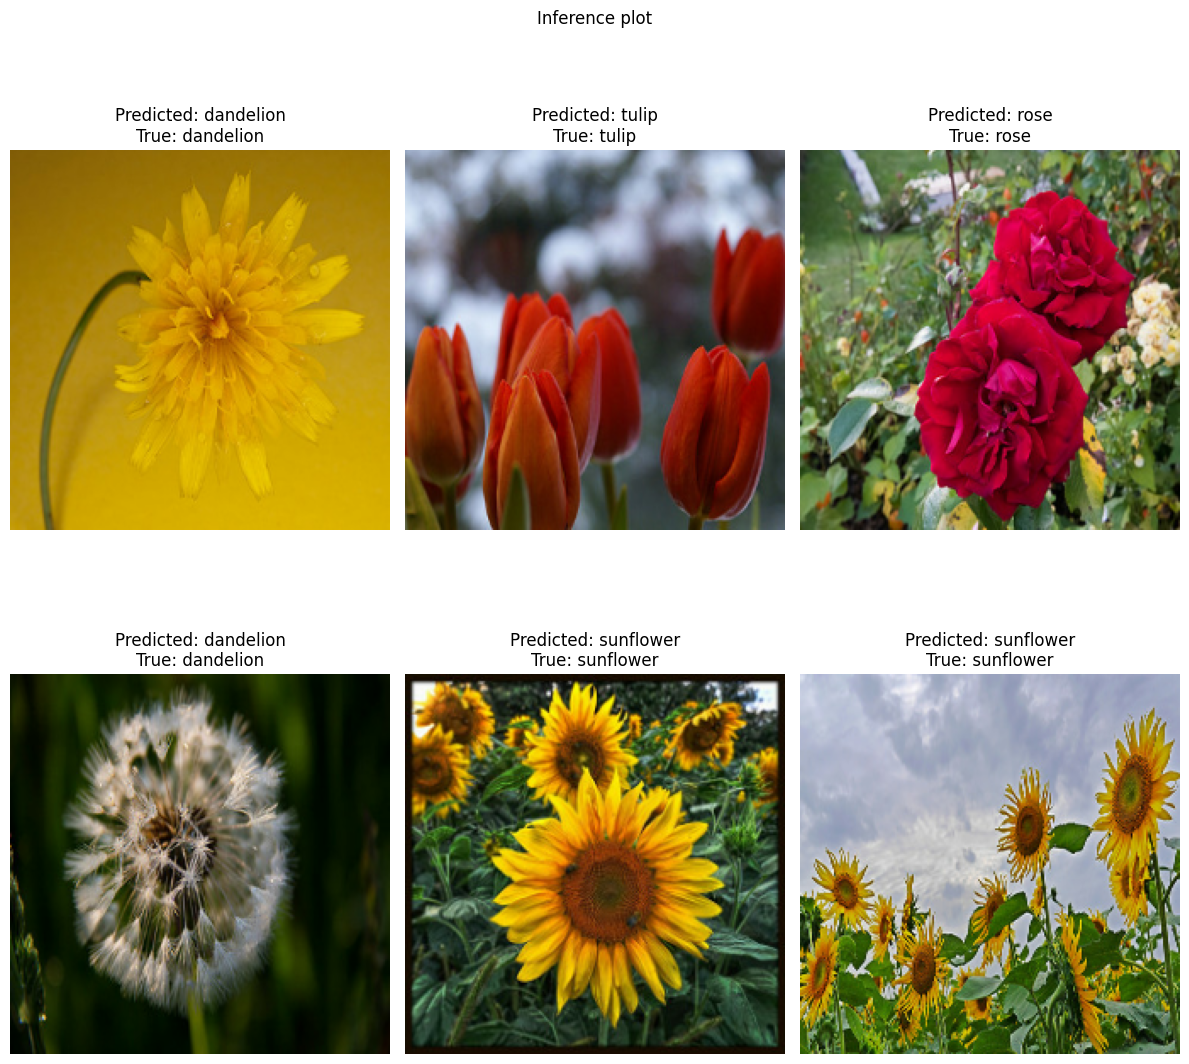

Test Accuracy: 1.0000


In [51]:
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, test_ds, class_labels=None):
    predicted_labels = []
    true_labels = []

    fig, axes = plt.subplots(2, 3, figsize=(12, 12))
    fig.suptitle("Inference plot", fontsize=12)

    for i, (images, labels) in enumerate(test_ds.take(2 * 3)):
        predictions = model.predict(images)

        predicted_label = np.argmax(predictions, axis=1)[0]
        true_label = np.argmax(labels.numpy(), axis=1)[0]

        predicted_labels.append(predicted_label)
        true_labels.append(true_label)

        ax = axes[i // 3, i % 3]
        ax.imshow(images[0].numpy())
        ax.set_title(f"Predicted: {class_labels[predicted_label]}\nTrue: {class_labels[true_label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))

    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy, predicted_labels, true_labels

accuracy, predicted_labels, true_labels = test_model(regularized_adam, test_ds, class_labels=class_names)


# Running inference on new images

1/1 [==============================] - 0s 29ms/step


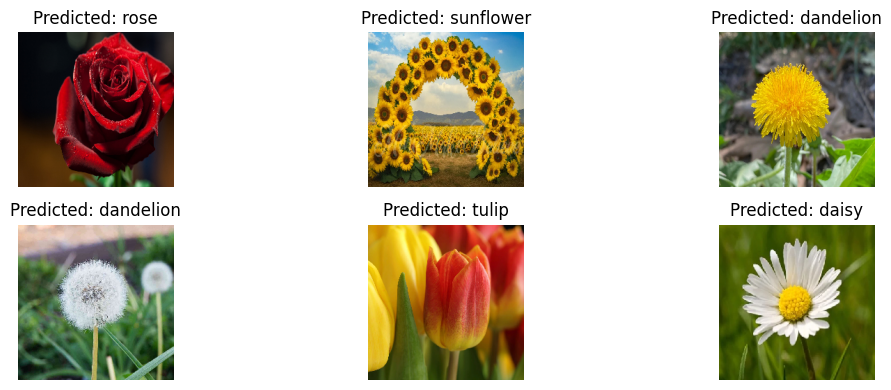

In [53]:
from tensorflow.keras.preprocessing import image

def predict_flower(model, image_paths, class_labels=None, grid_size=(1, 3)):
    predicted_labels = []

    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 

        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions, axis=1)[0]
        predicted_labels.append(predicted_label)

        if rows == 1:
            ax = axes[i % cols]
        else:
            ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.set_title(f"Predicted: {class_labels[predicted_label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

image_paths = [f"../Labb/Assets/cnn_test_images/{i}.jpg" for i in range(6)]
predicted_labels = predict_flower(regularized_adam, image_paths, class_labels=class_names, grid_size=(2, 3))


# Conclusion

In conclusion, etc. etc. The importance of quality data, impact of regularization. Validation accuracy score vs actual classification, difference in images etc. # TODO

Write a more abstract or more technical description?

#TODO Save figures as png probably, save model, move everything to one script and create function that takes image url to make prediction.